In [1]:
import ee
ee.Initialize()
from iteru import *
from IPython.display import display
import ipywidgets
import datetime

In [2]:
Map = Map()
Map

Map(center=[27, 31], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Sea…

In [19]:
aoi = Map.aoi

In [20]:
start_year = 2020
start_month = 1
start_day = 1
end_year = 2022
end_month = 1
end_day = 1
time_delta = 30

In [21]:
CLOUD_FILTER = 40
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

In [22]:
start_date = datetime.date(start_year,start_month,start_day)
end_date = datetime.date(end_year,end_month,end_day)
ee_start_date = f'{start_year}-{start_month}-{start_day}'
ee_end_date = f'{end_year}-{end_month}-{end_day}'

In [23]:
dates_list = get_dates_list(start_date ,end_date, time_delta)

In [24]:
def get_s2_sr_cld_col(aoi, ee_start_date, ee_end_date, CLOUD_FILTER):

    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
                 .filterBounds(aoi)
                 .filterDate(ee_start_date, ee_end_date)
                 .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
                        .filterBounds(aoi)
                        .filterDate(ee_start_date, ee_end_date))

    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [25]:
s2_sr_cld_col_eval = get_s2_sr_cld_col(aoi, ee_start_date, ee_end_date, CLOUD_FILTER)

In [26]:
def add_cloud_bands(img):
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')
    return img.addBands(ee.Image([cld_prb, is_cloud]))   

In [27]:
def add_shadow_bands(img):
    
    not_water = img.select('SCL').neq(6)

    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    img_cloud = add_cloud_bands(img)

    img_cloud_shadow = add_shadow_bands(img_cloud)

    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    not_cld_shdw = img.select('cloudmask').Not()

    return img.select('B.*').updateMask(not_cld_shdw).clip(aoi)

s2_sr_cld_col_eval = s2_sr_cld_col_eval.map(add_cld_shdw_mask).map(apply_cld_shdw_mask)

In [28]:
def get_images(day_date):
    
    start_day = ee.Date(day_date)
    end_day = start_day.advance(time_delta,'day')
    
    return s2_sr_cld_col_eval.filterDate(start_day,end_day).reduce(ee.Reducer.median())\
          .set({'start_day':start_day.format('YYYY-MM-dd')})\
          .set({'end_day':end_day.format('YYYY-MM-dd')})

In [29]:
images = ee.List(dates_list).map(get_images)

In [30]:
collection = ee.ImageCollection.fromImages(images)

In [31]:
def add_ndwi(img):
    
    ndwi = img.normalizedDifference(['B3_median', 'B8_median'])
    ndwiMasked = ndwi.updateMask(ndwi.gte(0)).rename('NDWI')
    areaImage = ndwiMasked.multiply(ee.Image.pixelArea()).rename('NDWI_AREA')
    
    return img.addBands(ee.Image([ndwiMasked,areaImage]))

In [32]:
def ndwi_area(img):
    
    ndwi_area = img.select('NDWI_AREA').reduceRegion(reducer = ee.Reducer.sum(),geometry = aoi, crs =  'EPSG:4326',scale = 100)

    return img.set({'NDWI_Area':ndwi_area })



In [33]:
collection = collection.map(add_ndwi).map(ndwi_area)

In [34]:
l = collection.aggregate_array('NDWI_Area').getInfo()

In [35]:
areas = [item['NDWI_AREA']/(1e6) for item in l]

In [36]:
videoArgs = {
  'dimensions': 900 ,
  'region': aoi,
  'framesPerSecond':3,
  'crs': 'EPSG:3857',
  'min':0,
  'max':5000,
  'bands':['B4_median','B3_median','B2_median']
  
        }
    

In [37]:
url = collection.getVideoThumbURL(videoArgs)

In [38]:
out_gif = get_gif(url)

In [39]:
add_text_to_gif(out_gif,dates_list, dates_font_size = 25, dates_font_color = 'white', framesPerSecond = 2 )

In [40]:
display_gif(out_gif)

Output()

In [41]:
videoArgs = {
  'dimensions': 900 ,
  'region': aoi,
  'framesPerSecond':3,
  'crs': 'EPSG:3857',
  'min': 0.5,
  'max': 1,
  'palette': ['00FFFF', '0000FF'],
  'bands':['NDWI']
        }
url = collection.getVideoThumbURL(videoArgs)
out_gif = get_gif(url)
add_text_to_gif(out_gif,dates_list, dates_font_size = 25, dates_font_color = 'white', framesPerSecond = 2 )

In [42]:
display_gif(out_gif)

Output()

In [43]:
import matplotlib.pyplot as plt

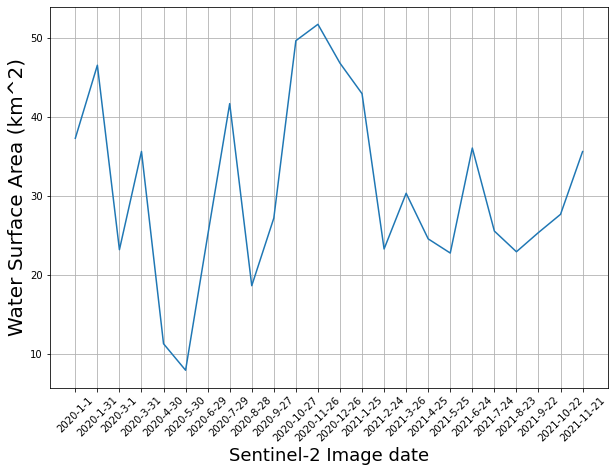

In [44]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.xlabel('Sentinel-2 Image date',fontsize=18)
plt.ylabel('Water Surface Area (km^2)',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.plot(dates_list,areas)